## Charts: 
## (EDA)
for trends? for example: correlation matrix, bar chart; 
the infor helps with assumption;
expectations what we might see in the future; 
such as, mean, variance,...;
## Presentation;
Story Line;
Data....;
Tarblo
Power Point;

# ICR - Identifying Age-Related Conditions Dataset with TensorFlow Decision Forests

## Steps & Sections:
#1. EDA

#2.Preprocessing the data (clean, merge, encode) 

#3. Feature Engineering

#4. ML Model Training and Evaluation
The decision tree has no assumptions about distribution because of the non-parametric nature of the algorithm.

#5. Feature Importance Analysis

In [1]:
import numpy as np 
import pandas as pd 
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train= pd.read_csv(r'/kaggle/input/icr-identify-age-related-conditions/train.csv')
test = pd.read_csv(r"/kaggle/input/icr-identify-age-related-conditions/test.csv")
greeks=pd.read_csv(r'/kaggle/input/icr-identify-age-related-conditions/greeks.csv')

## EDA

In [3]:
print('train head:\n',train.head(3))
print('greeks head:\n',greeks.head(3))
print('test head:\n',test)

train head:
              Id        AB          AF         AH         AM        AR  \
0  000ff2bfdfe9  0.209377  3109.03329  85.200147  22.394407  8.138688   
1  007255e47698  0.145282   978.76416  85.200147  36.968889  8.138688   
2  013f2bd269f5  0.470030  2635.10654  85.200147  32.360553  8.138688   

         AX        AY         AZ        BC  ...        FL       FR        FS  \
0  0.699861  0.025578   9.812214  5.555634  ...  7.298162  1.73855  0.094822   
1  3.632190  0.025578  13.517790  1.229900  ...  0.173229  0.49706  0.568932   
2  6.732840  0.025578  12.824570  1.229900  ...  7.709560  0.97556  1.198821   

          GB         GE            GF         GH         GI         GL  Class  
0  11.339138  72.611063   2003.810319  22.136229  69.834944   0.120343      1  
1   9.292698  72.611063  27981.562750  29.135430  32.131996  21.978000      0  
2  37.077772  88.609437  13676.957810  28.022851  35.192676   0.196941      0  

[3 rows x 58 columns]
greeks head:
              Id 

In [4]:
#Basic information
print(train.info())
print(greeks.info())
print(test.info())
# Describe the data
print(train.describe())
print(greeks.describe())
print(test.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

In [5]:
# show how many IDs include null values
print('**********For Training data**********')
print('# of null rows',sum([True for idx,row in train.iterrows() if any(row.isnull())]))
# show how many null cells in the data
print('# of null cells',sum(train.isnull().values.ravel()))
print(np.shape(train))
print('**********For Testing data**********')
print('# of null rows',sum([True for idx,row in test.iterrows() if any(row.isnull())]))
# show how many null cells in the data
print('# of null cells',sum(test.isnull().values.ravel()))
print(np.shape(test))

**********For Training data**********
# of null rows 69
# of null cells 131
(617, 58)
**********For Testing data**********
# of null rows 0
# of null cells 0
(5, 57)


In [6]:
#Find the duplicates
print(train.duplicated().sum())
print(greeks.duplicated().sum())

0
0


In [7]:
# Get the column names in train dataset
train.columns

Index(['Id', 'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Class'],
      dtype='object')

##  Based on observation, we decided to drop the samples contains null value, because most of (63/69) the incomplete samples are labeled as 0, which is the dominant class.

In [8]:
# Get the indexes according to the ids'/samples/rows which include null values in train dataset
null_rows_indices = train[train.isnull().any(axis=1)].index
print(null_rows_indices)
null_ids = train.loc[null_rows_indices, 'Id']
print(len(null_ids))
print('null_class count', train.loc[null_rows_indices, 'Class'].value_counts())
# Based on observation, we decided to drop the samples contains null value, because most of (63/69) the incomplete samples are labeled as 0, which is the dominant class.

Int64Index([  8,  15,  18,  23,  24,  45,  46,  48,  64,  71,  88, 114, 119,
            125, 128, 153, 166, 177, 178, 196, 231, 233, 235, 236, 244, 253,
            263, 264, 266, 272, 279, 281, 283, 285, 289, 304, 305, 316, 330,
            341, 356, 358, 363, 364, 369, 375, 422, 449, 458, 469, 471, 490,
            492, 507, 516, 517, 529, 537, 562, 568, 570, 573, 579, 582, 583,
            594, 602, 603, 615],
           dtype='int64')
69
null_class count 0    63
1     6
Name: Class, dtype: int64


In [9]:
# Drop the rows with the specified IDs in Greek data
greeks_noNull = greeks[~greeks['Id'].isin(null_ids)]
# Reset the index if needed
greeks.reset_index(drop=True, inplace=True)

In [10]:
#Considering the ratio of the null rows is not that large, so I'll try to drop it first.
train_dropnull = train.dropna(axis=0)

In [11]:
# # maybe drop the missing data is better than replace the missing value
# test=test.fillna(method='ffill') #propagate last valid observation forward to next valid
# train = train.fillna(method = 'ffill')

(56, 56)


Text(0.5, 1.0, 'Correlation Map (56, 56)')

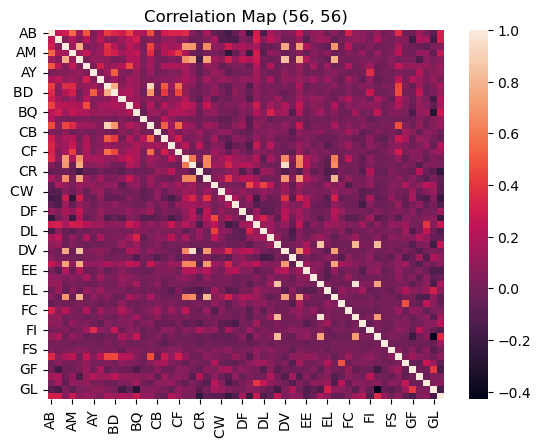

In [12]:
train_for_correlation = train_dropnull.select_dtypes(include=['float','double', 'int'])
#Correlation 
cor_shape = np.shape(train_for_correlation.corr())
print(cor_shape)
#Correlation plot
sns.heatmap(train_for_correlation.corr())
plt.title('Correlation Map (%s, %s)'%(cor_shape[0], cor_shape[1]))

In [13]:
plt.savefig('/kaggle/working/correlation map')

<Figure size 640x480 with 0 Axes>

/tmp/ipykernel_19/815061538.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train.corr()


Text(0.5, 1.0, 'Correlation Map (56, 56)')

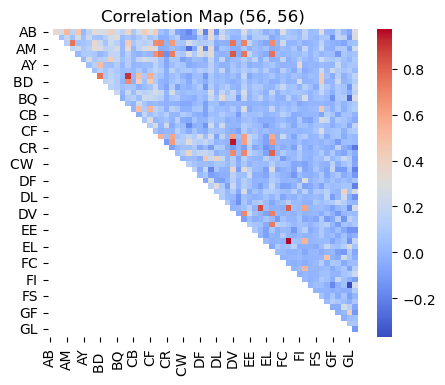

In [14]:
# Correlation between different variables
corr = train.corr()
# Set up the matplotlib plot configuration
f, ax = plt.subplots(figsize=(5, 4))
# Generate a mask for lower traingle
mask = np.tril(np.ones_like(corr, dtype=bool))
# Configure a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap
sns.heatmap(corr, annot=False, mask = mask, cmap='coolwarm')
plt.title('Correlation Map (%s, %s)'%(cor_shape[0], cor_shape[1]))

In [15]:
plt.savefig('/kaggle/working/triangle correlation map')

<Figure size 640x480 with 0 Axes>

                 AB            AF            AH            AM            AR  \
count  5.480000e+02  5.480000e+02  5.480000e+02  5.480000e+02  5.480000e+02   
mean  -7.131360e-17 -1.426272e-16 -1.296611e-17  6.483054e-17 -6.483054e-18   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -9.553228e-01 -1.450956e+00 -2.498893e-01 -5.076394e-01 -1.888039e-01   
25%   -5.470055e-01 -5.715330e-01 -2.498893e-01 -3.784774e-01 -1.888039e-01   
50%   -3.063416e-01 -1.807908e-01 -2.498893e-01 -2.602276e-01 -1.888039e-01   
75%    2.263638e-01  3.791165e-01 -8.235009e-02 -1.295139e-02 -1.888039e-01   
max    1.005572e+01  1.103929e+01  1.331538e+01  8.645264e+00  1.548312e+01   

                 AX            AY            AZ            BC         BD   \
count  5.480000e+02  5.480000e+02  5.480000e+02  5.480000e+02  548.000000   
mean  -1.620764e-17  2.917374e-17 -2.974101e-16  6.483054e-18    0.000000   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000

Text(0.5, 1.0, 'Box plot of 54 normalized statistical features')

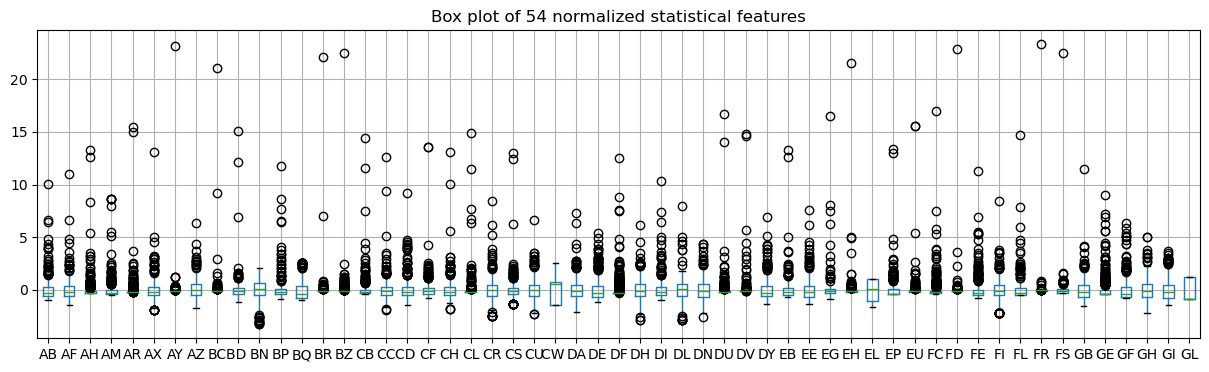

In [16]:
# copy the data to drop targets
df_z_scaled = train_for_correlation.copy()
df_z_scaled = df_z_scaled[df_z_scaled.columns[:-1]]
# apply normalization techniques
for column in df_z_scaled.columns:
    df_z_scaled[column] = (df_z_scaled[column] - df_z_scaled[column].mean()) / df_z_scaled[column].std()
# view normalized data
# display(df_z_scaled)
# Describe the data
# print(train.describe())
print(df_z_scaled.describe())
#Boxplot
fig = plt.figure(figsize =(15, 4))
 
# Creating axes instance
# plt.ylim([0,10])
df_z_scaled[df_z_scaled.columns].boxplot()
plt.title('Box plot of %s normalized statistical features'%len(df_z_scaled.columns[:-1]))

In [17]:
plt.savefig('/kaggle/working/boxplot')

<Figure size 640x480 with 0 Axes>

In [18]:
# Merge the training data and greeks
# train_g = pd.merge(train, greeks, how = 'left', on = 'Id')
# train_g.head(3)
# train_dropnull.dtypes

# Observe the categorical variate

In [19]:
print(train_dropnull['EJ'])
print(train_dropnull['EJ'].value_counts())
print(test['EJ'].value_counts())

0      B
1      A
2      B
3      B
4      B
      ..
611    A
612    A
613    B
614    A
616    A
Name: EJ, Length: 548, dtype: object
B    329
A    219
Name: EJ, dtype: int64
A    5
Name: EJ, dtype: int64


# Encode the alphabet categorical data to numerical categorical data

In [20]:
train_encoded = train_dropnull.replace({'EJ':{'A':0, 'B':1}})
test_encoded = test.replace({'EJ':{'A':0, 'B':1}})

In [21]:
# print(train_encoded['EJ'])
print(train_encoded['EJ'].value_counts())
print(test_encoded['EJ'].value_counts())

1    329
0    219
Name: EJ, dtype: int64
0    5
Name: EJ, dtype: int64


# We have an imbalanced trainig data:
we'll need to discuss how to deal with the imbalanced data later on

0    446
1    102
Name: Class, dtype: int64


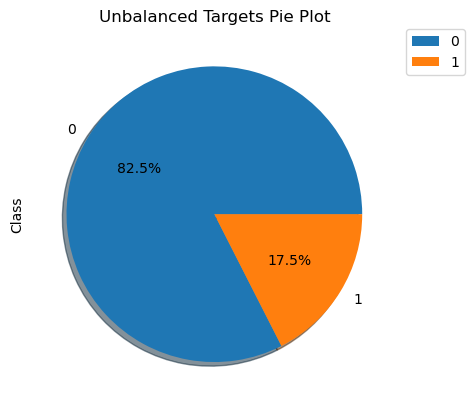

In [22]:
labels = ['0', '1']
print(train_dropnull['Class'].value_counts())
plot_df = train.Class.value_counts()
ax = plot_df.plot(kind="pie",labels=labels, legend= True,autopct='%1.1f%%', shadow=True, title='Unbalanced Targets Pie Plot')
ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()
# plot

In [23]:
plt.savefig('/kaggle/working/Unbalanced Targets Pie Plot')

<Figure size 640x480 with 0 Axes>

In [24]:
# # #shows that all null value is in BQ and EL feature:
# # train_encoded.isnull().sum()
# # Check that all data cells are not 'null' 
# np.shape(train_encoded.isnull().sum())

In [25]:
X = train_encoded[train_encoded.columns[1:-1]]
y = train_encoded['Class']
X_test = test_encoded[test_encoded.columns[1:]]
print(len(train_encoded.columns))
print(len(test_encoded.columns))
print(X.shape, y.shape, X_test.shape)

58
57
(548, 56) (548,) (5, 56)


In [26]:
# copy the data to drop targets
df_data_scaled = X.copy()
# apply normalization techniques
for column in df_z_scaled.columns:
    df_data_scaled[column] = (df_data_scaled[column] - df_data_scaled[column].mean()) / df_data_scaled[column].std()
# view normalized data
# display(df_z_scaled)
# Describe the data
# print(train.describe())
print(df_data_scaled.describe())

                 AB            AF            AH            AM            AR  \
count  5.480000e+02  5.480000e+02  5.480000e+02  5.480000e+02  5.480000e+02   
mean  -7.131360e-17 -1.426272e-16 -1.296611e-17  6.483054e-17 -6.483054e-18   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -9.553228e-01 -1.450956e+00 -2.498893e-01 -5.076394e-01 -1.888039e-01   
25%   -5.470055e-01 -5.715330e-01 -2.498893e-01 -3.784774e-01 -1.888039e-01   
50%   -3.063416e-01 -1.807908e-01 -2.498893e-01 -2.602276e-01 -1.888039e-01   
75%    2.263638e-01  3.791165e-01 -8.235009e-02 -1.295139e-02 -1.888039e-01   
max    1.005572e+01  1.103929e+01  1.331538e+01  8.645264e+00  1.548312e+01   

                 AX            AY            AZ            BC         BD   \
count  5.480000e+02  5.480000e+02  5.480000e+02  5.480000e+02  548.000000   
mean  -1.620764e-17  2.917374e-17 -2.974101e-16  6.483054e-18    0.000000   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000

In [27]:
def train_test_val_split(df, train_size, val_size, test_size, random_state=42):
    """
    Splits a pandas dataframe into training, validation, and test sets.

    Args:
    - df: pandas dataframe to split.
    - train_size: float between 0 and 1 indicating the proportion of the dataframe to include in the training set.
    - val_size: float between 0 and 1 indicating the proportion of the dataframe to include in the validation set.
    - test_size: float between 0 and 1 indicating the proportion of the dataframe to include in the test set.
    - random_state: int or None, optional (default=42). The seed used by the random number generator.

    Returns:
    - train_df: pandas dataframe containing the training set.
    - val_df: pandas dataframe containing the validation set.
    - test_df: pandas dataframe containing the test set.

    Raises:
    - AssertionError: if the sum of train_size, val_size, and test_size is not equal to 1.
    """

    assert train_size + val_size + test_size == 1, "Train, validation, and test sizes must add up to 1."
    
    # Split the dataframe into training and test sets
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state)
    
    # Calculate the size of the validation set relative to the original dataframe
    val_ratio = val_size / (1 - test_size)
    
    # Split the training set into training and validation sets
    train_df, val_df = train_test_split(train_df, test_size=val_ratio, random_state=random_state)
    
    return train_df, val_df, test_df

In [28]:
# print(np.shape(greeks), np.shape(greeks_noNull))
# greeks.drop(columns=['Epsilon'])

# # Perform one-hot encoding
# encoded_greeks = pd.get_dummies(greeks_noNull, columns=greeks_noNull.columns[1:])
# encoded_greeks[encoded_greeks.columns[1:]] =  encoded_greeks[encoded_greeks.columns[1:]].astype(float)
# # Print the encoded DataFrame
# print(encoded_greeks.head(),'\n', np.shape(encoded_greeks))#

In [29]:
# import pandas as pd
# import numpy as np

def locate_in_df(df, value):
    a = df.to_numpy()
    row = np.where(a == value)[0][0]
    col = np.where(a == value)[1][0]
    return row, col

In [30]:
# print(train_encoded.iloc[1][40])
# locate_in_df(train_encoded, 'B')
# Merged_train = pd.merge(train_encoded,encoded_greeks, on="Id")
# print(Merged_train.head())
# train_noID = Merged_train.iloc[:,1:56]
# greeks_noID = Merged_train.iloc[:,57:-1]
# print(train_noID.shape, greeks_noID.shape)
# print(train_noID.head(3), greeks_noID.head(3))

## Canonical Correlation Analysis (CCA) 
 is a technique used to explore the relationship between two sets of variables. We try to analysis the correlation between the greeks data and train data

In [31]:
# import numpy as np
# from sklearn.decomposition import PCA
# from scipy.linalg import eig, pinv
# # def is_singular(matrix, tolerance=1e-10):
# #     singular_values = np.linalg.svd(matrix, compute_uv=False)
# #     min_singular_value = np.min(singular_values)
# #     return min_singular_value < tolerance
# pca = PCA(n_components=5)  
# X_1_reduced = pca.fit_transform(train_noID[train_noID.columns[1:]].values)
# X_2_reduced = pca.fit_transform(encoded_greeks[encoded_greeks.columns[1:]].values)
# X =  np.concatenate((X_1_reduced, X_2_reduced), axis=1)
# print(np.shape(np.cov(X, rowvar=False)))
# print(np.shape(X_1_reduced))
# print(np.shape(X_2_reduced))
# print(np.shape(np.cov(X_1_reduced.T)))
# print(np.shape(np.cov(X_1_reduced, X_2_reduced, rowvar=False)))

# # # 应用CCA

# # # def cca(X1, X2):
# # #     # Standardize the variables
# # # #     X1 = (X1 - np.mean(X1, axis=0)) / np.std(X1, axis=0)
# # # #     X2 = (X2 - np.mean(X2, axis=0)) / np.std(X2, axis=0)
# # # #     y = (y - np.mean(y)) / np.std(y)

# # #     # Concatenate the variables
# # # #     X = np.concatenate((X_1, X_2), axis=1)

# # #     # Compute the covariance matrices
# # #     cov_xx = np.var(X1, axis=0)
    
# # #     cov_yy = np.var(X2, axis=0)
# # #     cov_xy = np.cov(X1, X2, rowvar=False)
# # # #     print("Matrix cov_xx is singular:", is_singular(cov_xx))
# # #     print('cov_xx',np.shape(cov_xx), '\n cov_yy',np.shape(cov_yy), '\n cov_xy',np.shape(cov_xy))

# # #     # Perform singular value decomposition (SVD)
# # #     S1, V1 = eig(np.dot(np.dot(np.dot(np.linalg.pinv(cov_xx), cov_xy), np.linalg.inv(cov_yy)), cov_xy.T))
# # #     S2, V2 = eig(np.dot(np.dot(np.dot(np.linalg.inv(cov_yy), cov_xy.T), np.linalg.inv(cov_xx)), cov_xy))

# # #     # Extract canonical variables
# # #     X1_canonical = np.dot(X1, V1[:, 0])
# # #     X2_canonical = np.dot(X2, V2[:, 0])

# # #     return X_1_canonical, X_2_canonical



# # # X_1_canonical, X_2_canonical = cca(X_1_reduced, X_2_reduced)

# # # # 打印结果
# # # print("Canonical variables for X_1:")
# # # print(X_1_canonical)
# # # print("Canonical variables for X_2:")
# # # print(X_2_canonical)


# # # Perform CCA
# # # X_1_canonical, X_2_canonical = cca(train_noID[train_noID.columns[1:]].values, encoded_greeks[encoded_greeks.columns[1:]].values)

# # # # Print the canonical variables
# # # print("Canonical variables for X_1:")
# # # print(X_1_canonical)
# # # print("Canonical variables for X_2:")
# # # print(X_2_canonical)

## Decitsion Tree Model without utilizing Greek data

In [32]:
def train_test_val_split(X, y, train_size, val_size, test_size, random_state=42):
    """
    Splits X and y into training, validation, and test sets.

    Args:
    - X: pandas dataframe or array containing the independent variables.
    - y: pandas series or array containing the dependent variable.
    - train_size: float between 0 and 1 indicating the proportion of the data to include in the training set.
    - val_size: float between 0 and 1 indicating the proportion of the data to include in the validation set.
    - test_size: float between 0 and 1 indicating the proportion of the data to include in the test set.
    - random_state: int or None, optional (default=42). The seed used by the random number generator.

    Returns:
    - X_train: pandas dataframe or array containing the independent variables for the training set.
    - X_val: pandas dataframe or array containing the independent variables for the validation set.
    - X_test: pandas dataframe or array containing the independent variables for the test set.
    - y_train: pandas series or array containing the dependent variable for the training set.
    - y_val: pandas series or array containing the dependent variable for the validation set.
    - y_test: pandas series or array containing the dependent variable for the test set.

    Raises:
    - AssertionError: if the sum of train_size, val_size, and test_size is not equal to 1.
    """

    assert train_size + val_size + test_size == 1, "Train, validation, and test sizes must add up to 1."
    
    # Concatenate X and y into a single dataframe
    df = pd.concat([X, y], axis=1)
    
    # Split the dataframe into training and test sets
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state)
    
    # Calculate the size of the validation set relative to the original dataframe
    val_ratio = val_size / (1 - test_size)
    
    # Split the training set into training and validation sets
    train_df, val_df = train_test_split(train_df, test_size=val_ratio, random_state=random_state)
    
    # Split the training, validation, and test dataframes into X and y values
    X_train, y_train = train_df.drop(columns=y.name), train_df[y.name]
    X_val, y_val = val_df.drop(columns=y.name), val_df[y.name]
    X_test, y_test = test_df.drop(columns=y.name), test_df[y.name]
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [33]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import svm, tree
from sklearn.ensemble import RandomForestClassifier

In [34]:
import numpy as np
from sklearn.decomposition import PCA
from scipy.linalg import eig, pinv
# def is_singular(matrix, tolerance=1e-10):
#     singular_values = np.linalg.svd(matrix, compute_uv=False)
#     min_singular_value = np.min(singular_values)
#     return min_singular_value < tolerance
pca = PCA(n_components=10)  
X_PCA = pca.fit_transform(X)

# X_PCA = pd.DataFrame(X_PCA, columns=['F0','F1','F2','F3','F4','F5','F6','F7','F8','F9'])

In [35]:
print(X.shape)
print(X_PCA.shape)

(548, 56)
(548, 10)


In [36]:
# X_PCA.head(2)

# Split the Data into training, validation and testing data

In [37]:
train_size=0.7
test_size=0.2
val_size=0.1
X_train, X_val, X_test, y_train, y_val, y_test =  train_test_val_split(X=X, y=y, train_size=train_size, test_size=test_size,val_size=val_size, random_state=42)

In [38]:

max_depth = 5
clf = tree.DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=max_depth)

# tree.plot_tree(clf)

## Decision Tree with imbalancing data

[0.         0.         0.01612964 0.01175039 0.         0.
 0.         0.         0.0877518  0.02350079 0.02741759 0.03041279
 0.         0.         0.         0.         0.01717249 0.01410047
 0.         0.         0.         0.10803993 0.         0.03133439
 0.         0.         0.10391884 0.         0.         0.
 0.         0.         0.32640305 0.         0.         0.02222564
 0.01710719 0.         0.         0.         0.         0.04863319
 0.         0.         0.         0.07427928 0.03982253 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
[32 21 26  8 45 41 46 23 11 10  9 35 16 36  2 17  3 18 15 19 20 55 14 13
 12  7  6  5  4  1 22 27 24 25 53 52 51 50 49 48 47 44 43 42 40 39 38 37
 34 33 31 30 29 28 54  0]


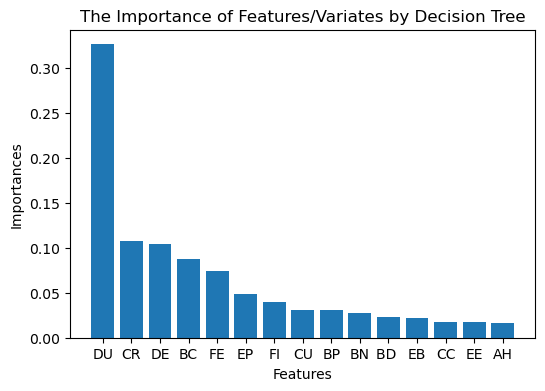

Index(['DU', 'CR', 'DE', 'BC', 'FE', 'EP', 'FI', 'CU', 'BP', 'BN', 'BD ', 'EB',
       'CC', 'EE', 'AH'],
      dtype='object')


In [39]:
clf = clf.fit(X_train, y_train)
feature_importances = clf.feature_importances_
print(feature_importances)
sorted_indices = feature_importances.argsort()[::-1]
print(sorted_indices)
sorted_feature_names = X_train.columns[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# Create a bar plot of the feature importances
# sns.set(rc={'figure.figsize':(11.7,8.27)})
# sns.barplot(sorted_importances, sorted_feature_names)
# Creating the bar plot
fig = plt.figure(figsize =(6, 4))
plt.bar(sorted_feature_names[:15],sorted_importances[0:15])

# Optional: Adding labels and title

plt.xlabel('Features')
plt.ylabel('Importances')
plt.title('The Importance of Features/Variates by Decision Tree')

# Display the plot
plt.show()
print(sorted_feature_names[:15])

In [40]:
plt.savefig('/kaggle/working/The Importance of Variates by Decision Tree')

<Figure size 640x480 with 0 Axes>

In [41]:
# import os
# folder_path = '/kaggle/working/The Importance of Variates.png'
# os.remove(folder_path)

In [42]:
from sklearn.tree import export_graphviz
export_graphviz(clf,'tree.dot', feature_names=train_encoded.columns[1:-1])

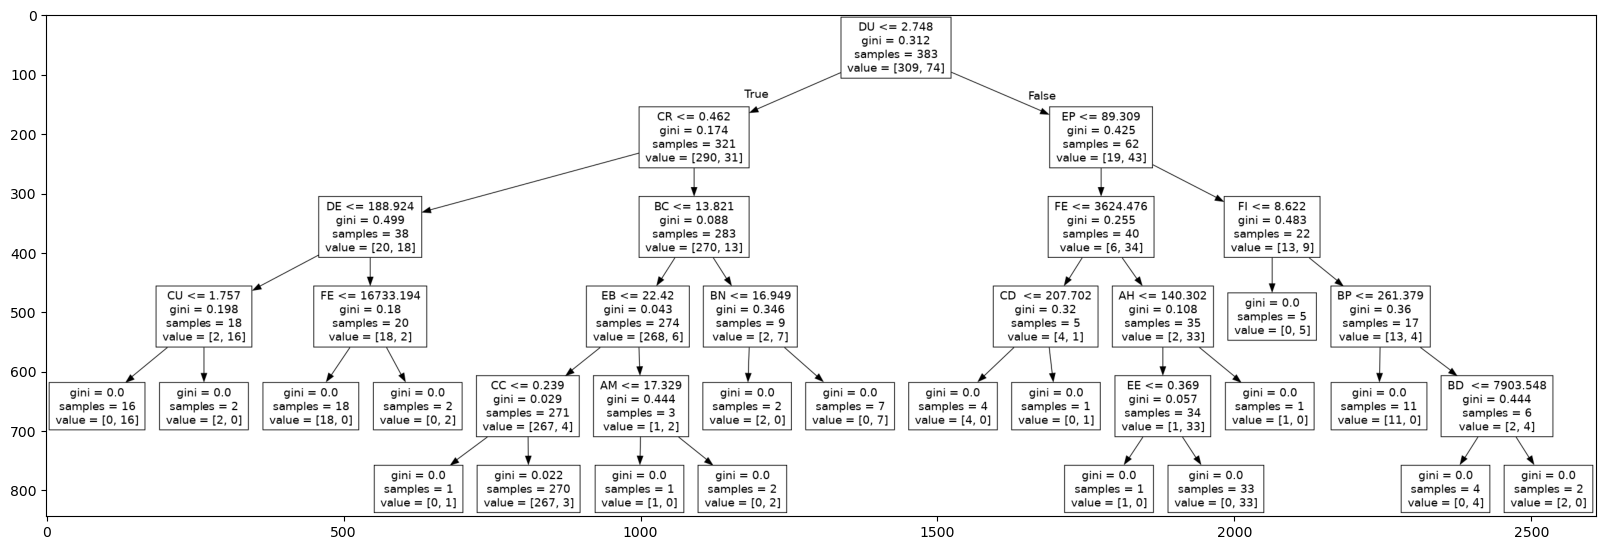

In [43]:
import matplotlib.pyplot as plt
import cv2
! dot -Tpng tree.dot -o tree.png
%matplotlib inline
img = cv2.imread('tree.png')
plt.figure(figsize = (20, 20))
plt.imshow(img)
# print('the predicted probabilities are:\n',clf.predict_proba(X_test))

In [44]:
plt.savefig('/kaggle/working/Decision Tree')

<Figure size 640x480 with 0 Axes>

In [45]:
print('test_accuracy:\n', clf.score(X_test, y_test))
print('validation accuracy:\n', clf.score(X_val, y_val))

test_accuracy:
 0.8818181818181818
validation accuracy:
 0.8545454545454545


In [46]:
y_test_hat = clf.predict(X_test)
y_val_hat = clf.predict(X_val)
print('Classification Report for testing data:\n', classification_report(y_test, y_test_hat))
print('Classification Report for validation data:\n', classification_report(y_val, y_val_hat))

Classification Report for testing data:
               precision    recall  f1-score   support

           0       0.88      0.99      0.93        92
           1       0.86      0.33      0.48        18

    accuracy                           0.88       110
   macro avg       0.87      0.66      0.71       110
weighted avg       0.88      0.88      0.86       110

Classification Report for validation data:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91        45
           1       0.60      0.60      0.60        10

    accuracy                           0.85        55
   macro avg       0.76      0.76      0.76        55
weighted avg       0.85      0.85      0.85        55



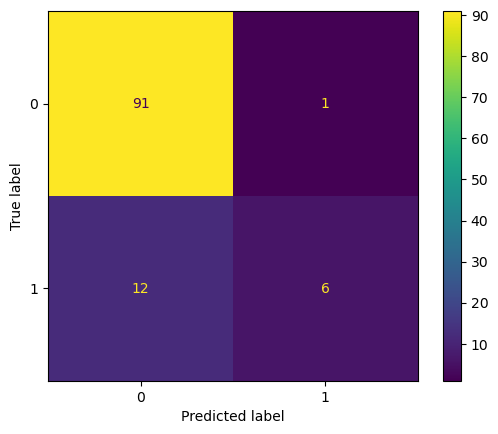

In [47]:

from sklearn import metrics
test_confusion_matrix = metrics.confusion_matrix(y_test, y_test_hat)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = test_confusion_matrix, display_labels = ['0', '1'])
cm_display.plot()
plt.show()

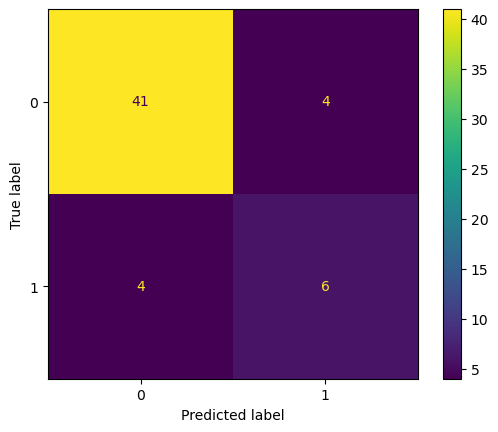

In [48]:
val_confusion_matrix = metrics.confusion_matrix(y_val, y_val_hat)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = val_confusion_matrix, display_labels = ['0', '1'])
cm_display.plot()
plt.show()

## Decision Tree with balanced data

# Balance the data by upersampling

In [49]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
over_sampler = RandomOverSampler(random_state=42)
X_res, y_res = over_sampler.fit_resample(X_train, y_train)
X_res_test, y_res_test = over_sampler.fit_resample(X_test, y_test)
X_res_val, y_res_val = over_sampler.fit_resample(X_val, y_val)

print(f"Training target statistics: {Counter(y_train)}")
print(f"Training target statistics: {Counter(y_val)}")
print(f"Testing target statistics: {Counter(y_test)}")
print(f"Training target statistics: {Counter(y_res)}")

print(f"Training target statistics: {Counter(y_res_val)}")
print(f"Testing target statistics: {Counter(y_res_test)}")

Training target statistics: Counter({0: 309, 1: 74})
Training target statistics: Counter({0: 45, 1: 10})
Testing target statistics: Counter({0: 92, 1: 18})
Training target statistics: Counter({1: 309, 0: 309})
Training target statistics: Counter({0: 45, 1: 45})
Testing target statistics: Counter({0: 92, 1: 92})


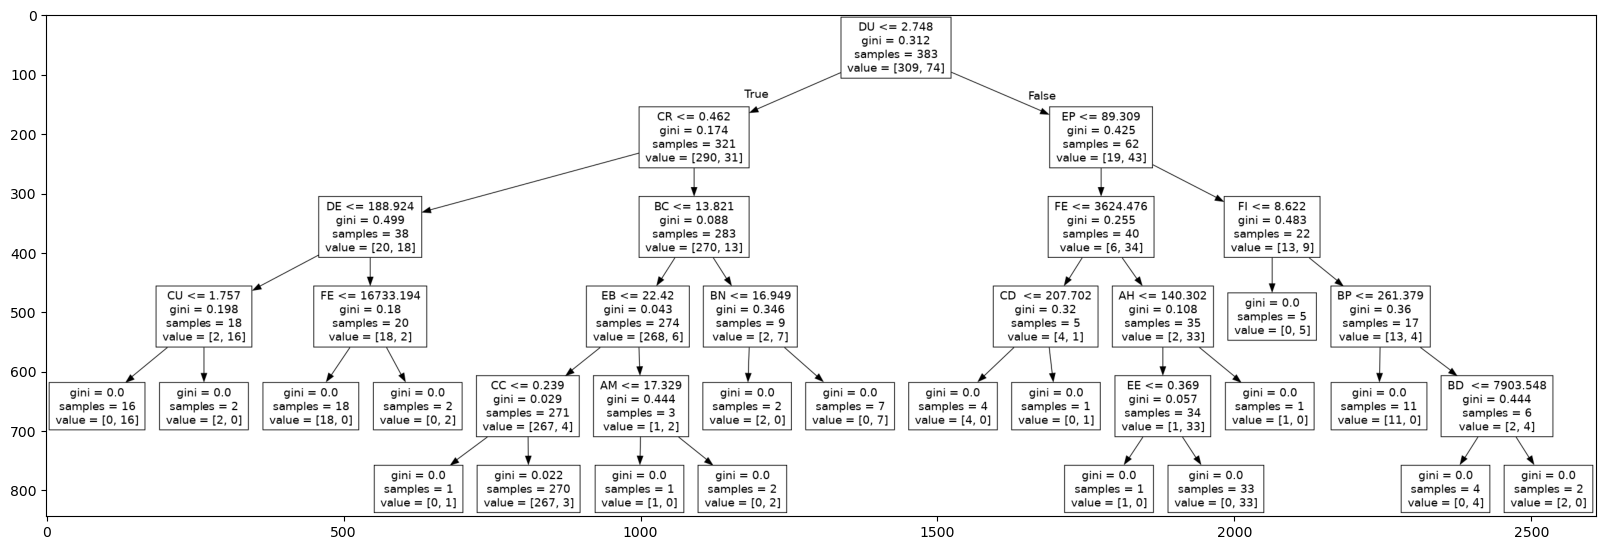

In [50]:
max_depth = 5
# clf = tree.DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=max_depth)
clf = clf.fit(X_res, y_res)
# tree.plot_tree(clf)
! dot -Tpng tree.dot -o tree.png
%matplotlib inline
img = cv2.imread('tree.png')
plt.figure(figsize = (20, 20))
plt.imshow(img)

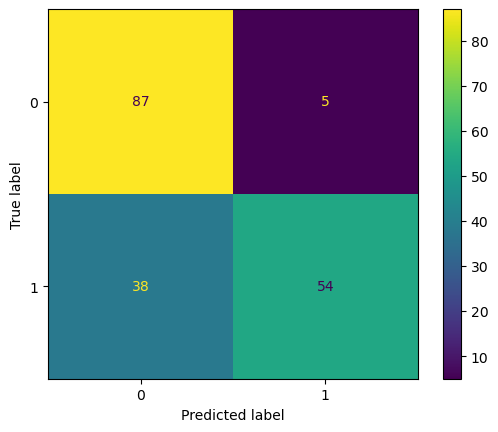

In [51]:

# print('the predicted probabilities are:\n',clf.predict_proba(X_test))
y_train_hat = clf.predict(X_res)
y_test_hat = clf.predict(X_res_test)
y_val_hat = clf.predict(X_res_val)
from sklearn import metrics
test_confusion_matrix = metrics.confusion_matrix(y_res_test, y_test_hat)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = test_confusion_matrix, display_labels = ['0', '1'])
cm_display.plot()
plt.show()

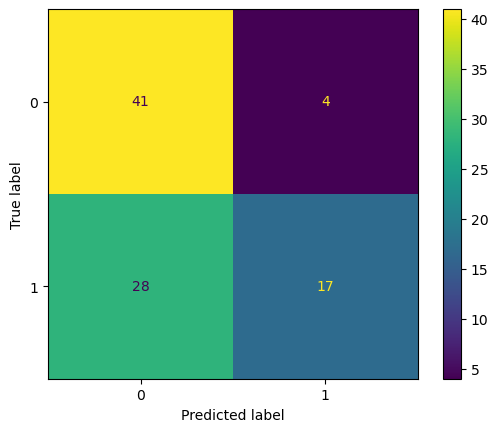

In [52]:
val_confusion_matrix = metrics.confusion_matrix(y_res_val, y_val_hat)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = val_confusion_matrix, display_labels = ['0', '1'])
cm_display.plot()
plt.show()

## Random Forest with Imbalanced Data

[0.02666584 0.02688708 0.00388937 0.01963751 0.00582247 0.01280939
 0.00453086 0.00702161 0.02397567 0.00597741 0.00801948 0.00770074
 0.02110996 0.00914556 0.00406002 0.01595356 0.02183798 0.01517276
 0.01051981 0.0096181  0.00449403 0.03221764 0.0083345  0.01135702
 0.00322474 0.03626714 0.03546678 0.01133143 0.02090574 0.01818957
 0.00881802 0.01598626 0.08205829 0.00156893 0.01098338 0.01678925
 0.02825535 0.01191028 0.0381156  0.00187389 0.00875515 0.00940634
 0.00554235 0.01008103 0.02750693 0.0117037  0.02402954 0.06979129
 0.03392351 0.0060858  0.00968585 0.00614089 0.02096904 0.01072381
 0.00802294 0.07912881]
[32 55 47 38 25 26 48 21 36 44  1  0 46  8 16 12 52 28  3 29 35 31 15 17
  5 37 45 23 27 34 53 18 43 50 19 41 13 30 40 22 54 10 11  7 51 49  9  4
 42  6 20 14  2 24 39 33]


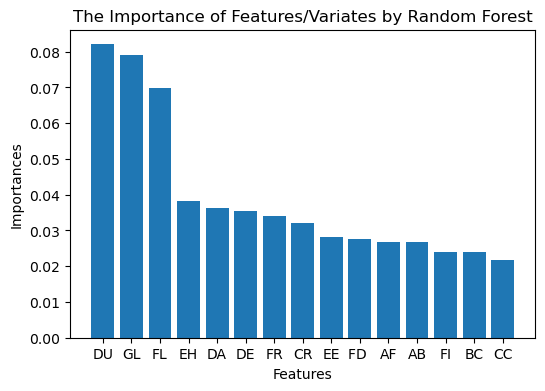

Index(['DU', 'GL', 'FL', 'EH', 'DA', 'DE', 'FR', 'CR', 'EE', 'FD ', 'AF', 'AB',
       'FI', 'BC', 'CC'],
      dtype='object')


In [53]:
clf_RF = RandomForestClassifier(max_depth=10, random_state=0)
clf_RF.fit(X_train, y_train)
feature_importances = clf_RF.feature_importances_
print(feature_importances)
sorted_indices = feature_importances.argsort()[::-1]
print(sorted_indices)
sorted_feature_names = X_train.columns[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# Create a bar plot of the feature importances
# sns.set(rc={'figure.figsize':(11.7,8.27)})
# sns.barplot(sorted_importances, sorted_feature_names)
# Creating the bar plot
fig = plt.figure(figsize =(6, 4))
plt.bar(sorted_feature_names[:15],sorted_importances[0:15])

# Optional: Adding labels and title

plt.xlabel('Features')
plt.ylabel('Importances')
plt.title('The Importance of Features/Variates by Random Forest')

# Display the plot
plt.show()
print(sorted_feature_names[:15])

In [54]:
y_test_hat = clf_RF.predict(X_test)
y_val_hat = clf_RF.predict(X_val)
y_train_hat = clf_RF.predict(X_train)
print('Classification Report for testing data:\n', classification_report(y_test, y_test_hat))
print('Classification Report for validation data:\n', classification_report(y_val, y_val_hat))
print('Classification Report for validation data:\n', classification_report(y_train, y_train_hat))

Classification Report for testing data:
               precision    recall  f1-score   support

           0       0.88      0.99      0.93        92
           1       0.83      0.28      0.42        18

    accuracy                           0.87       110
   macro avg       0.85      0.63      0.67       110
weighted avg       0.87      0.87      0.84       110

Classification Report for validation data:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95        45
           1       1.00      0.50      0.67        10

    accuracy                           0.91        55
   macro avg       0.95      0.75      0.81        55
weighted avg       0.92      0.91      0.90        55

Classification Report for validation data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       309
           1       1.00      1.00      1.00        74

    accuracy                           1.00       383

## Random Forest with upper Sampled balanced data

[0.05806387 0.04664272 0.00239337 0.00771001 0.00125482 0.00674885
 0.00229378 0.00644486 0.01899558 0.00918778 0.01295819 0.01191404
 0.03714339 0.00630504 0.00490096 0.0092664  0.0111872  0.0129841
 0.00686548 0.00786919 0.00537286 0.03141379 0.00643881 0.00836301
 0.00366005 0.03092694 0.03006537 0.00939288 0.01481324 0.01893439
 0.00792107 0.00700393 0.10132027 0.00076301 0.00750509 0.03740624
 0.04997304 0.00832083 0.03308707 0.00386842 0.00601025 0.00879568
 0.00494823 0.00633471 0.02001292 0.01159677 0.02188673 0.08225746
 0.01848151 0.00555544 0.00438644 0.00653794 0.02068673 0.01275609
 0.00420074 0.06787244]
[32 47 55  0 36  1 35 12 38 21 25 26 46 52 44  8 29 48 28 17 10 53 11 45
 16 27 15  9 41 23 37 30 19  3 34 31 18  5 51  7 22 43 13 40 49 20 42 14
 50 54 39 24  2  6  4 33]


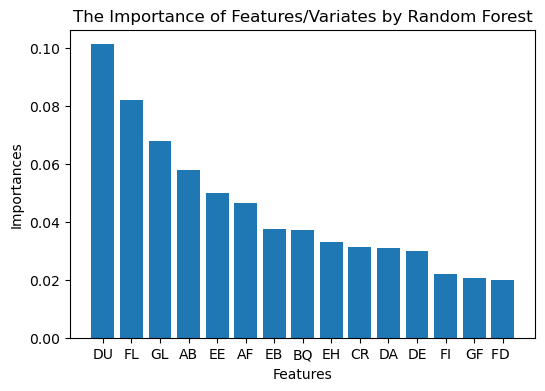

Index(['DU', 'FL', 'GL', 'AB', 'EE', 'AF', 'EB', 'BQ', 'EH', 'CR', 'DA', 'DE',
       'FI', 'GF', 'FD '],
      dtype='object')
Classification Report for testing data:
               precision    recall  f1-score   support

           0       0.65      0.96      0.78        92
           1       0.92      0.49      0.64        92

    accuracy                           0.72       184
   macro avg       0.79      0.72      0.71       184
weighted avg       0.79      0.72      0.71       184

Classification Report for validation data:
               precision    recall  f1-score   support

           0       0.73      0.96      0.83        45
           1       0.94      0.64      0.76        45

    accuracy                           0.80        90
   macro avg       0.83      0.80      0.80        90
weighted avg       0.83      0.80      0.80        90



In [55]:
clf_RF = RandomForestClassifier(max_depth=5, random_state=42)
clf_RF.fit(X_res, y_res)
feature_importances = clf_RF.feature_importances_
print(feature_importances)
sorted_indices = feature_importances.argsort()[::-1]
print(sorted_indices)
sorted_feature_names = X_train.columns[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# Create a bar plot of the feature importances
# sns.set(rc={'figure.figsize':(11.7,8.27)})
# sns.barplot(sorted_importances, sorted_feature_names)
# Creating the bar plot
fig = plt.figure(figsize =(6, 4))
plt.bar(sorted_feature_names[:15],sorted_importances[0:15])

# Optional: Adding labels and title

plt.xlabel('Features')
plt.ylabel('Importances')
plt.title('The Importance of Features/Variates by Random Forest')
# Display the plot
plt.show()
print(sorted_feature_names[:15])
y_test_hat = clf_RF.predict(X_res_test)
y_val_hat = clf_RF.predict(X_res_val)
print('Classification Report for testing data:\n', classification_report(y_res_test, y_test_hat))
print('Classification Report for validation data:\n', classification_report(y_res_val, y_val_hat))

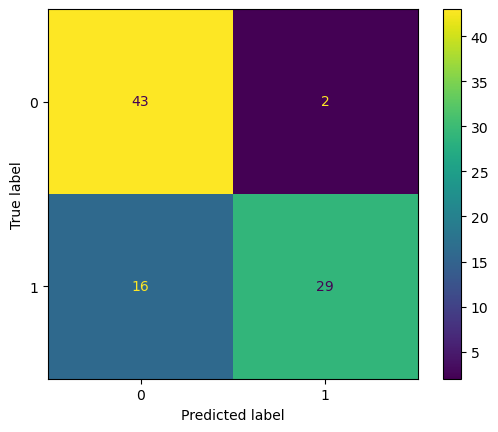

In [56]:
val_confusion_matrix = metrics.confusion_matrix(y_res_val, y_val_hat)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = val_confusion_matrix, display_labels = ['0', '1'])
cm_display.plot()
plt.show()

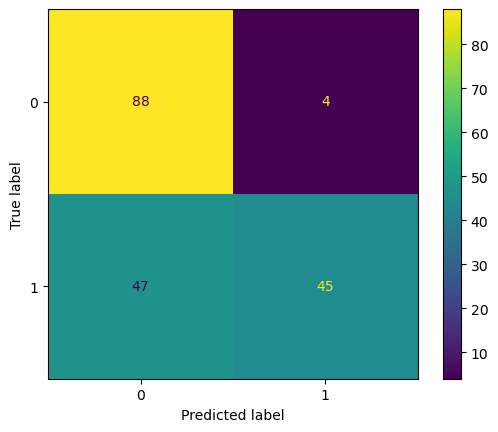

In [57]:
val_confusion_matrix = metrics.confusion_matrix(y_res_test, y_test_hat)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = val_confusion_matrix, display_labels = ['0', '1'])
cm_display.plot()
plt.show()

## GAM Model without considering Greek Data

In [58]:
import numpy as np
import pandas as pd
!pip install pygam
from pygam import GAM, LinearGAM, LogisticGAM, s, f, te

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.2/522.2 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 49.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.25.1 which is incompatible.
momepy 0.6.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
numba 0.57.1 requires numpy<1.25,>=1.21, but you have numpy 1.25.1 which is incompatible.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you have numpy 1.25.1 which is incompatible.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3

In [59]:
n_features = np.shape(X_test)[1]
print(n_features)
from pygam import GAM, LinearGAM,ExpectileGAM, LogisticGAM, s, f, te
clf_gam = LinearGAM(s(0, n_splines=20) + f(1,2) + te(3,4))
clf_gam = clf_gam.fit(X_train, y_train)

56


## GAM Model with imbalanced data

In [60]:
# print('the predicted probabilities are:\n',clf.predict_proba(X_test))
y_test_hat = clf_gam.predict(X_test)
print(y_test_hat)
y_test_hat = np.round(y_test_hat)
y_val_hat = clf_gam.predict(X_val)
y_val_hat = np.round(y_val_hat)

[ 0.17747959 -0.00569077  0.32565514  0.12601144  0.09580492  0.40371282
  0.19433744  0.10769419  0.37756596  0.05480711  0.12258711  0.13922699
  0.66715434  0.21928854  0.08569036  0.17090099  0.3709669   0.12748393
  0.21714118  0.23753564  0.15035674  0.13461614  0.28113233  0.14544678
  0.05703292  0.02968389  0.08727419  0.15662992  0.0225374   0.34885477
  0.50639166 -0.02787666  0.23604188  0.11569215  0.36437171  0.29786111
  0.16474323  0.22753615  0.28154298  0.14677002  0.0708156   0.1817459
  0.16819765  0.24426071  0.23544465 -0.03435036  0.34106024  0.22532096
  0.19780826 -0.01781304  0.15130435  0.19493951  0.14715603  0.16179003
  0.2332686   0.82629105  0.1708304   0.23148872  0.4394173   0.4169295
  0.15736091  0.38578511  0.1647973   0.28063527  0.05203769  0.19521989
  0.43984204  0.04143953  0.19364456  0.64721298  0.01737641  0.23626294
  0.00345895  0.19525977  0.03844367  0.17384786  0.05364799  0.1514776
  0.03574613  0.20771094  0.08463495  0.25021378  0.03

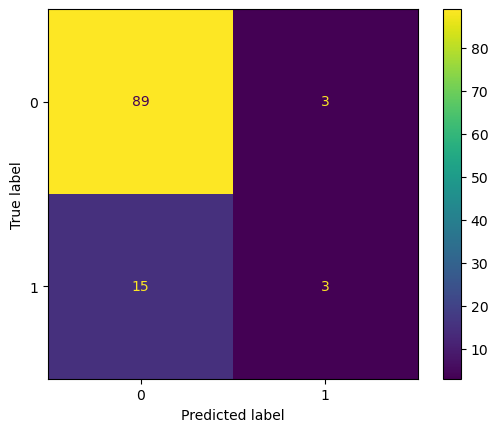

In [61]:
from sklearn import metrics
test_confusion_matrix = metrics.confusion_matrix(y_test, y_test_hat)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = test_confusion_matrix, display_labels = ['0', '1'])
cm_display.plot()
plt.show()

In [62]:
# from mpl_toolkits import mplot3d
# plt.ion()
# plt.rcParams['figure.figsize'] = (12, 8)
# XX = clf_gam.generate_X_grid(term=1, meshgrid=True)
# Z = clf_gam.partial_dependence(term=1, X=XX, meshgrid=True)
# ax = plt.axes(projection='3d')
# ax.plot_surface(XX[0], XX[1], Z, cmap='viridis')

In [63]:
print('the probability of test data with GAM is:\n', clf_gam.predict(X_test))

the probability of test data with GAM is:
 [ 0.17747959 -0.00569077  0.32565514  0.12601144  0.09580492  0.40371282
  0.19433744  0.10769419  0.37756596  0.05480711  0.12258711  0.13922699
  0.66715434  0.21928854  0.08569036  0.17090099  0.3709669   0.12748393
  0.21714118  0.23753564  0.15035674  0.13461614  0.28113233  0.14544678
  0.05703292  0.02968389  0.08727419  0.15662992  0.0225374   0.34885477
  0.50639166 -0.02787666  0.23604188  0.11569215  0.36437171  0.29786111
  0.16474323  0.22753615  0.28154298  0.14677002  0.0708156   0.1817459
  0.16819765  0.24426071  0.23544465 -0.03435036  0.34106024  0.22532096
  0.19780826 -0.01781304  0.15130435  0.19493951  0.14715603  0.16179003
  0.2332686   0.82629105  0.1708304   0.23148872  0.4394173   0.4169295
  0.15736091  0.38578511  0.1647973   0.28063527  0.05203769  0.19521989
  0.43984204  0.04143953  0.19364456  0.64721298  0.01737641  0.23626294
  0.00345895  0.19525977  0.03844367  0.17384786  0.05364799  0.1514776
  0.0357461

In [64]:
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 25.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.0
ERROR: Cannot uninstall numpy 1.25.0, RECORD file not found. You might be able to recover from this via: 'pip install --force-reinstall --no-deps numpy==1.25.0'.


## Classification via PCA

In [65]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

def perform_pca(X_train, X_test, n_components=2):
    # Initialize the PCA object with the desired number of components
    pca = PCA(n_components=n_components)
    
    # Fit and transform the training data
    X_train_pca = pca.fit_transform(X_train)
    
    # Transform the testing data using the learned PCA
    X_test_pca = pca.transform(X_test)
    
    return X_train_pca, X_test_pca

def binary_classification(X_train, y_train, X_test, y_test):
    # Perform PCA on the training and testing data
    X_train_pca, X_test_pca = perform_pca(X_train, X_test)

    # Create and train the Logistic Regression model
    model = LogisticRegression()
    model.fit(X_train_pca, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test_pca)
    
    # Print the classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

# Example usage:
# Assuming you have X_train, y_train, X_test, and y_test as your datasets